In [24]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import librosa 
import torch 
import torchaudio 
import torchaudio.functional as F 
import torchaudio.transforms as T 
from torch import Tensor 
import torch.nn as nn 
from torch.utils.data import DataLoader, random_split, Dataset
from IPython.display import Audio, display



In [25]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()


def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")


def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)


In [26]:
audio_path = '/Users/stephen/Desktop/Speech_Commands/Data/SpeechCommands/speech_commands_v0.02/'

In [27]:
# list of label_list 
label_list = os.listdir(audio_path)
label_list.remove('.DS_Store')
label_list.remove('validation_list.txt')
label_list.remove('LICENSE')
label_list.remove('testing_list.txt')
label_list.remove('README.md')
label_list

['right',
 'eight',
 'cat',
 'tree',
 'backward',
 'learn',
 'bed',
 'happy',
 'go',
 'dog',
 'no',
 'wow',
 'follow',
 'nine',
 'left',
 'stop',
 'three',
 '_background_noise_',
 'sheila',
 'one',
 'bird',
 'zero',
 'seven',
 'up',
 'visual',
 'marvin',
 'two',
 'house',
 'down',
 'six',
 'yes',
 'on',
 'five',
 'forward',
 'off',
 'four']

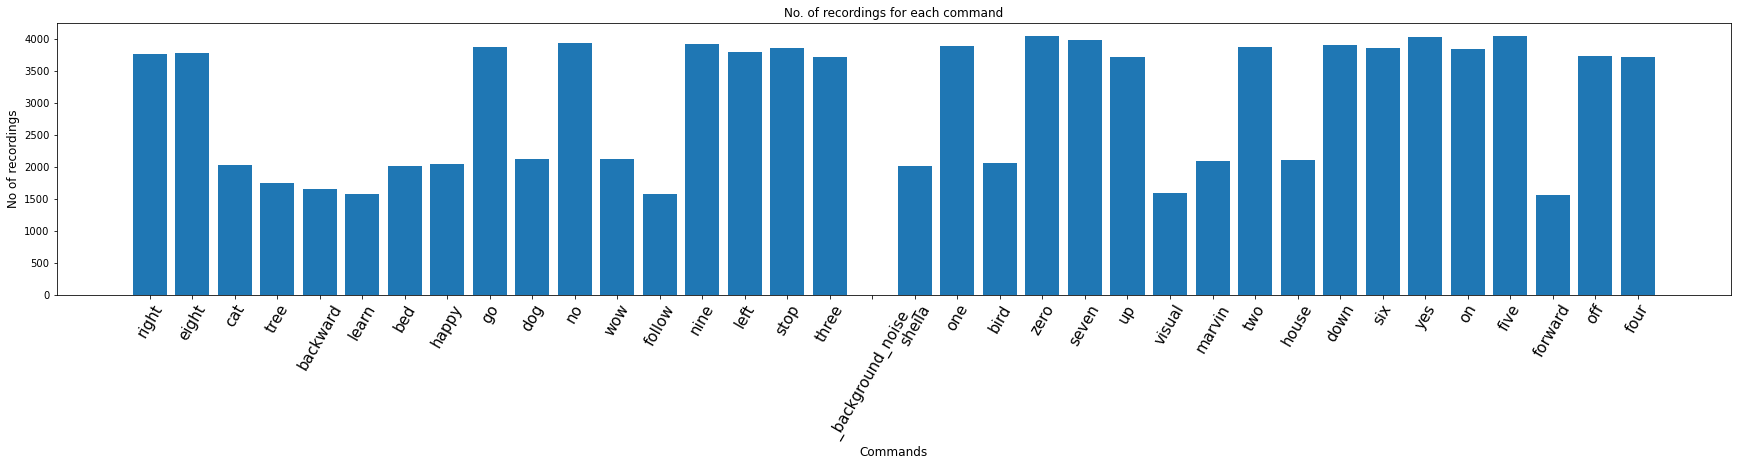

In [28]:
# count each label and plot results 
no_of_recordings = []
for label in label_list:
    waves = [f for f in os.listdir(audio_path + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

# plot 
plt.figure(figsize=(30,5))
index = np.arange(len(label_list))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, label_list, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [29]:
# selecting a random file. "forward"
test_file_path = '/Users/stephen/Desktop/Speech_Commands/Data/SpeechCommands/speech_commands_v0.02/forward/1a994c9f_nohash_3.wav'


In [30]:
waveform, sample_rate = torchaudio.load(test_file_path)

Sample Rate: 16000
Shape: (1, 16000)
Dtype: torch.float32
 - Max:      0.547
 - Min:     -0.318
 - Mean:     0.000
 - Std Dev:  0.072

tensor([[0.0002, 0.0002, 0.0002,  ..., 0.0012, 0.0012, 0.0012]])



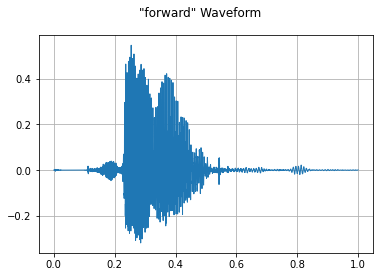

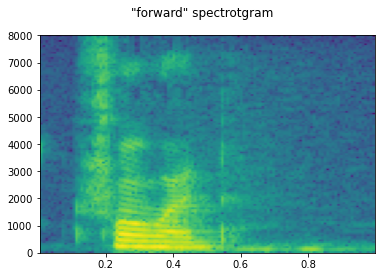

In [31]:
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate, title='"forward" Waveform')
plot_specgram(waveform, sample_rate, title='"forward" spectrotgram')
play_audio(waveform, sample_rate)

Shape: (1, 513, 32)
Dtype: torch.float32
 - Max:     1748.398
 - Min:      0.000
 - Mean:     1.937
 - Std Dev: 33.659

tensor([[[1.6290e-06, 2.8334e-07, 2.3487e-08,  ..., 1.6740e-03,
          2.8481e-04, 3.6512e-04],
         [3.1496e-06, 9.3471e-07, 5.4189e-07,  ..., 7.9350e-04,
          1.1353e-03, 2.1992e-04],
         [2.2417e-06, 1.0835e-06, 1.2982e-06,  ..., 9.1440e-05,
          7.9622e-04, 6.9843e-05],
         ...,
         [7.4558e-10, 1.6587e-08, 7.7284e-09,  ..., 2.9651e-08,
          1.3119e-07, 4.0401e-08],
         [2.3429e-11, 3.6097e-08, 1.8031e-08,  ..., 2.0644e-08,
          1.2795e-07, 1.0246e-07],
         [2.5222e-09, 1.3801e-08, 4.4074e-08,  ..., 5.8139e-08,
          2.3666e-07, 2.9103e-07]]])



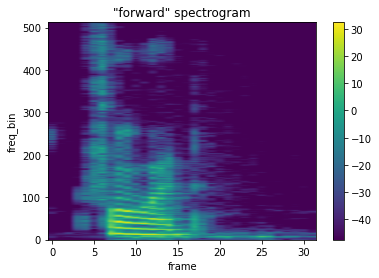

In [32]:
# Alternative way of looking at Spectrogram 

n_fft = 1024 
win_length = None 
hop_length = 512 

# define Transformation 
spectrogram = T.Spectrogram(
    n_fft=n_fft, 
    win_length=win_length, 
    center=True, 
    pad_mode='reflect',
    power=2.0
)

# perform transofrmation 
spec = spectrogram(waveform)

print_stats(spec)
plot_spectrogram(spec[0], title='"forward" spectrogram')

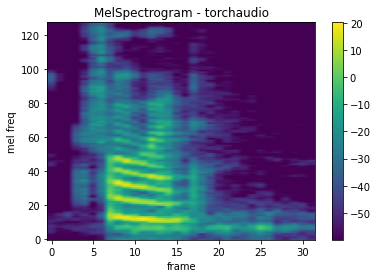

In [33]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')

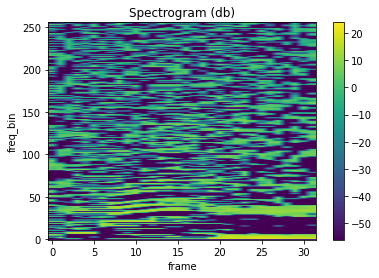

In [34]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0])

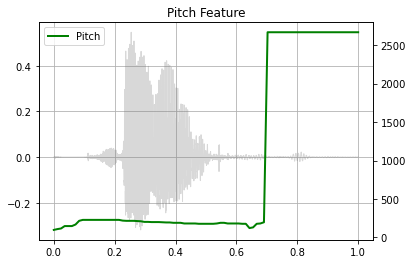

In [35]:
pitch = F.detect_pitch_frequency(waveform, sample_rate)
plot_pitch(waveform, sample_rate, pitch)
play_audio(waveform, sample_rate)

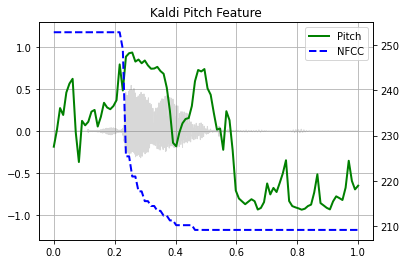

In [36]:
pitch_feature = F.compute_kaldi_pitch(waveform, sample_rate)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc)
play_audio(waveform, sample_rate)

In [37]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('<s>', '<pad>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [38]:
model = bundle.get_model()
print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [39]:


with torch.inference_mode():
    features, _ = model.extract_features(waveform)

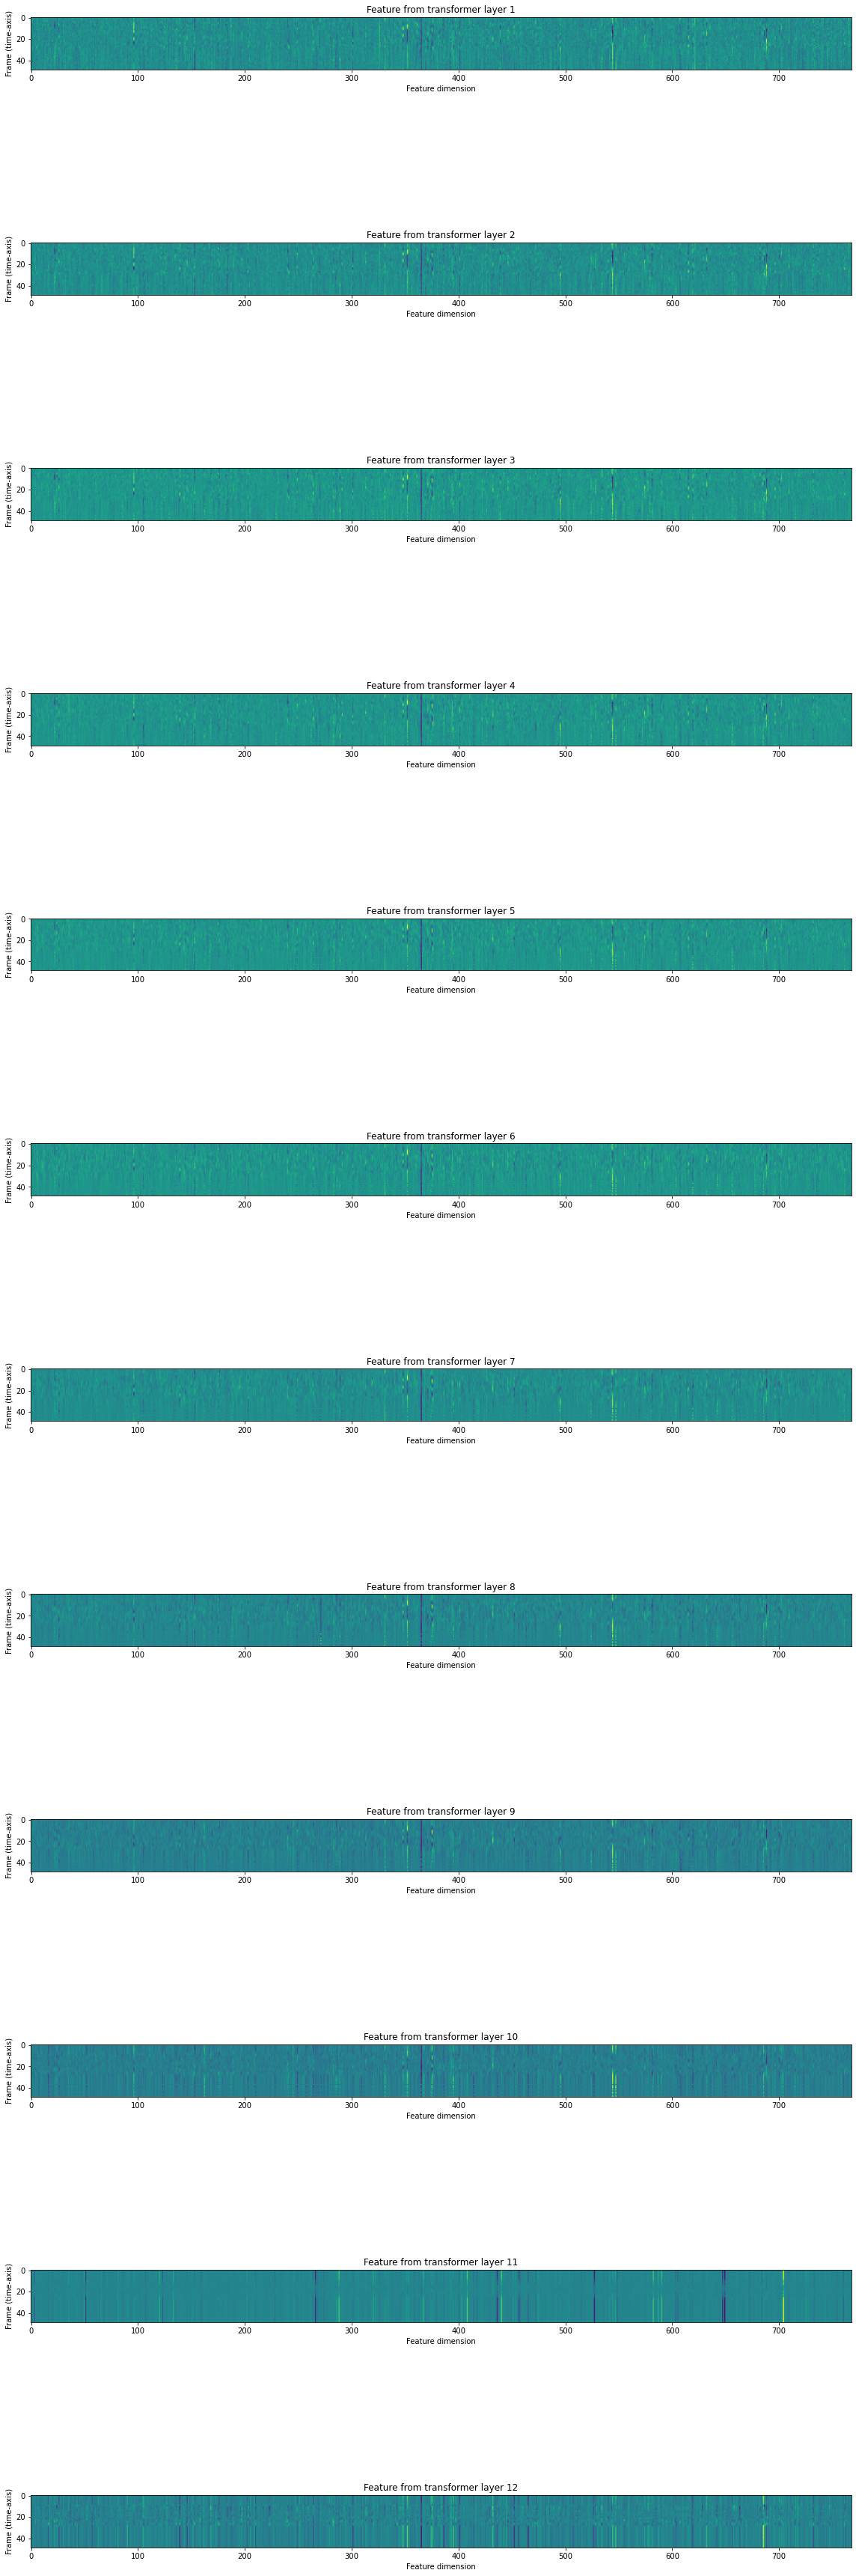

In [40]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
  ax[i].imshow(feats[0].cpu())
  ax[i].set_title(f"Feature from transformer layer {i+1}")
  ax[i].set_xlabel("Feature dimension")
  ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [41]:
with torch.inference_mode():
    emission, _ = model(waveform)

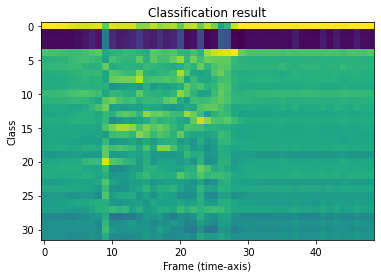

Class labels: ('<s>', '<pad>', '</s>', '<unk>', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [42]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [43]:
torchaudio.sox_effects.effect_names()

['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'biquad',
 'chorus',
 'channels',
 'compand',
 'contrast',
 'dcshift',
 'deemph',
 'delay',
 'dither',
 'divide',
 'downsample',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'fade',
 'fir',
 'firfit',
 'flanger',
 'gain',
 'highpass',
 'hilbert',
 'loudness',
 'lowpass',
 'mcompand',
 'norm',
 'oops',
 'overdrive',
 'pad',
 'phaser',
 'pitch',
 'rate',
 'remix',
 'repeat',
 'reverb',
 'reverse',
 'riaa',
 'silence',
 'sinc',
 'speed',
 'stat',
 'stats',
 'stretch',
 'swap',
 'synth',
 'tempo',
 'treble',
 'tremolo',
 'trim',
 'upsample',
 'vad',
 'vol']

In [44]:

waveforms = []
labels = []

for label in label_list:
    print(label)
    waves = [f for f in os.listdir(audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        signal, sample_rate = torchaudio.load(audio_path + label + '/' + wav)
        waveforms.append(signal)
        labels.append(label)


right
eight
cat
tree
backward
learn
bed
happy
go
dog
no
wow
follow
nine
left
stop
three
_background_noise_
sheila
one
bird
zero
seven
up
visual
marvin
two
house
down
six
yes
on
five
forward
off
four


torch.Tensor

In [51]:
class SpeechDataLoader(Dataset):
    def __init__(self, data, labels, label_list, transform=None): 
        self.data = data
        self.labels = labels
        self.label_list = label_list
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform = self.data[idx]

        if self.transform != None:
            waveform = self.transform(waveform)


        if self.labels[idx] in self.label_list:
            out_labels = self.label_list.index(self.labels[idx])

        return waveform, out_labels


In [52]:
dataset = SpeechDataLoader(waveforms, labels, label_list)

In [60]:
train_data, test_data = random_split(dataset, [round(len(dataset)*.8), round(len(dataset)*.2)])

trainloader = DataLoader(train_data, batch_size=100, shuffle=True)

testloader = DataLoader(test_data, batch_size=100, shuffle=True)

In [59]:
trainloader

In [62]:
# Display image and label.
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

RuntimeError: stack expects each tensor to be equal size, but got [1, 16000] at entry 0 and [1, 14678] at entry 13